### 0. 导库，懒得后面重复导

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud
import jieba
from jieba import posseg  # 通过词性进行过滤
from gensim.models import Word2Vec
from collections import Counter
import sys
import asyncio
import logging
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MinMaxScaler
import numpy as np

### 1. 数据的加载

#### 1.1 加载数据到sum_data

In [1]:
data_path = f"data/sum_data.csv"
if os.path.exists(data_path):
    sum_data = pd.read_csv("data/sum_data.csv")
else:
    # 加载 CSV 文件
    comment_data = pd.read_csv('data/comment_data.csv')
    info_data = pd.read_csv('data/info_data.csv')
    # 去除含有空值的行，尤其是 eid 列中的空值
    comment_data = comment_data.dropna(subset=['eid'])
    info_data = info_data.dropna(subset=['eid'])
     #  'eid' 是用于链接两个数据表的字段
    sum_data = pd.merge(info_data, comment_data, on='eid', how='inner')
    # 保存合并后的数据到新 CSV 文件
    sum_data.to_csv('data/sum_data.csv', index=False)
print(sum_data.head(10))

     eid         name_usuall                   name_official       brand  \
0  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
1  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
2  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
3  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
4  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
5  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
6  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
7  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
8  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   
9  20985  NANOFLARE 700 TOUR  2NF-700TEX NF700TOUR 疾光700TOUR  尤尼克斯 YONEX   

  series launch_date racket_weight racket_length grip_thickness  \
0   疾光系列   2024年9月下旬         4U、5U        675mm           G5、G6   
1   疾光系列   2024年9月下旬         

In [2]:
print(sum_data.describe())

                eid     price_new     price_old  comment_star
count  89616.000000  89616.000000  89616.000000  89616.000000
mean    9696.705220   1326.022552    792.403778      4.524795
std     4116.167529   1122.688253    621.856426      0.730879
min       31.000000     31.000000     25.000000      1.000000
25%     6903.000000    595.000000    400.000000      4.000000
50%     8569.000000   1096.000000    745.000000      5.000000
75%    11410.000000   1666.000000   1052.000000      5.000000
max    21453.000000  27999.000000  22399.000000      5.000000


#### 1.2 查看数据的列名

In [3]:
print(list(sum_data.columns))

['eid', 'name_usuall', 'name_official', 'brand', 'series', 'launch_date', 'racket_weight', 'racket_length', 'grip_thickness', 'stringing_tension', 'price_new', 'price_old', 'comment_id', 'comment_star', 'comment', 'comment_ava_star']


#### 1.3 解决matlap字体不支持中文

In [4]:
# 设置中文字体为 Microsoft YaHei（微软雅黑）
rcParams['font.family'] = ['Microsoft YaHei']
# 解决负号显示问题
rcParams['axes.unicode_minus'] = False

### 2. 数据的探索

#### 2.1 查看热度最大的一些羽毛球拍的评论分布

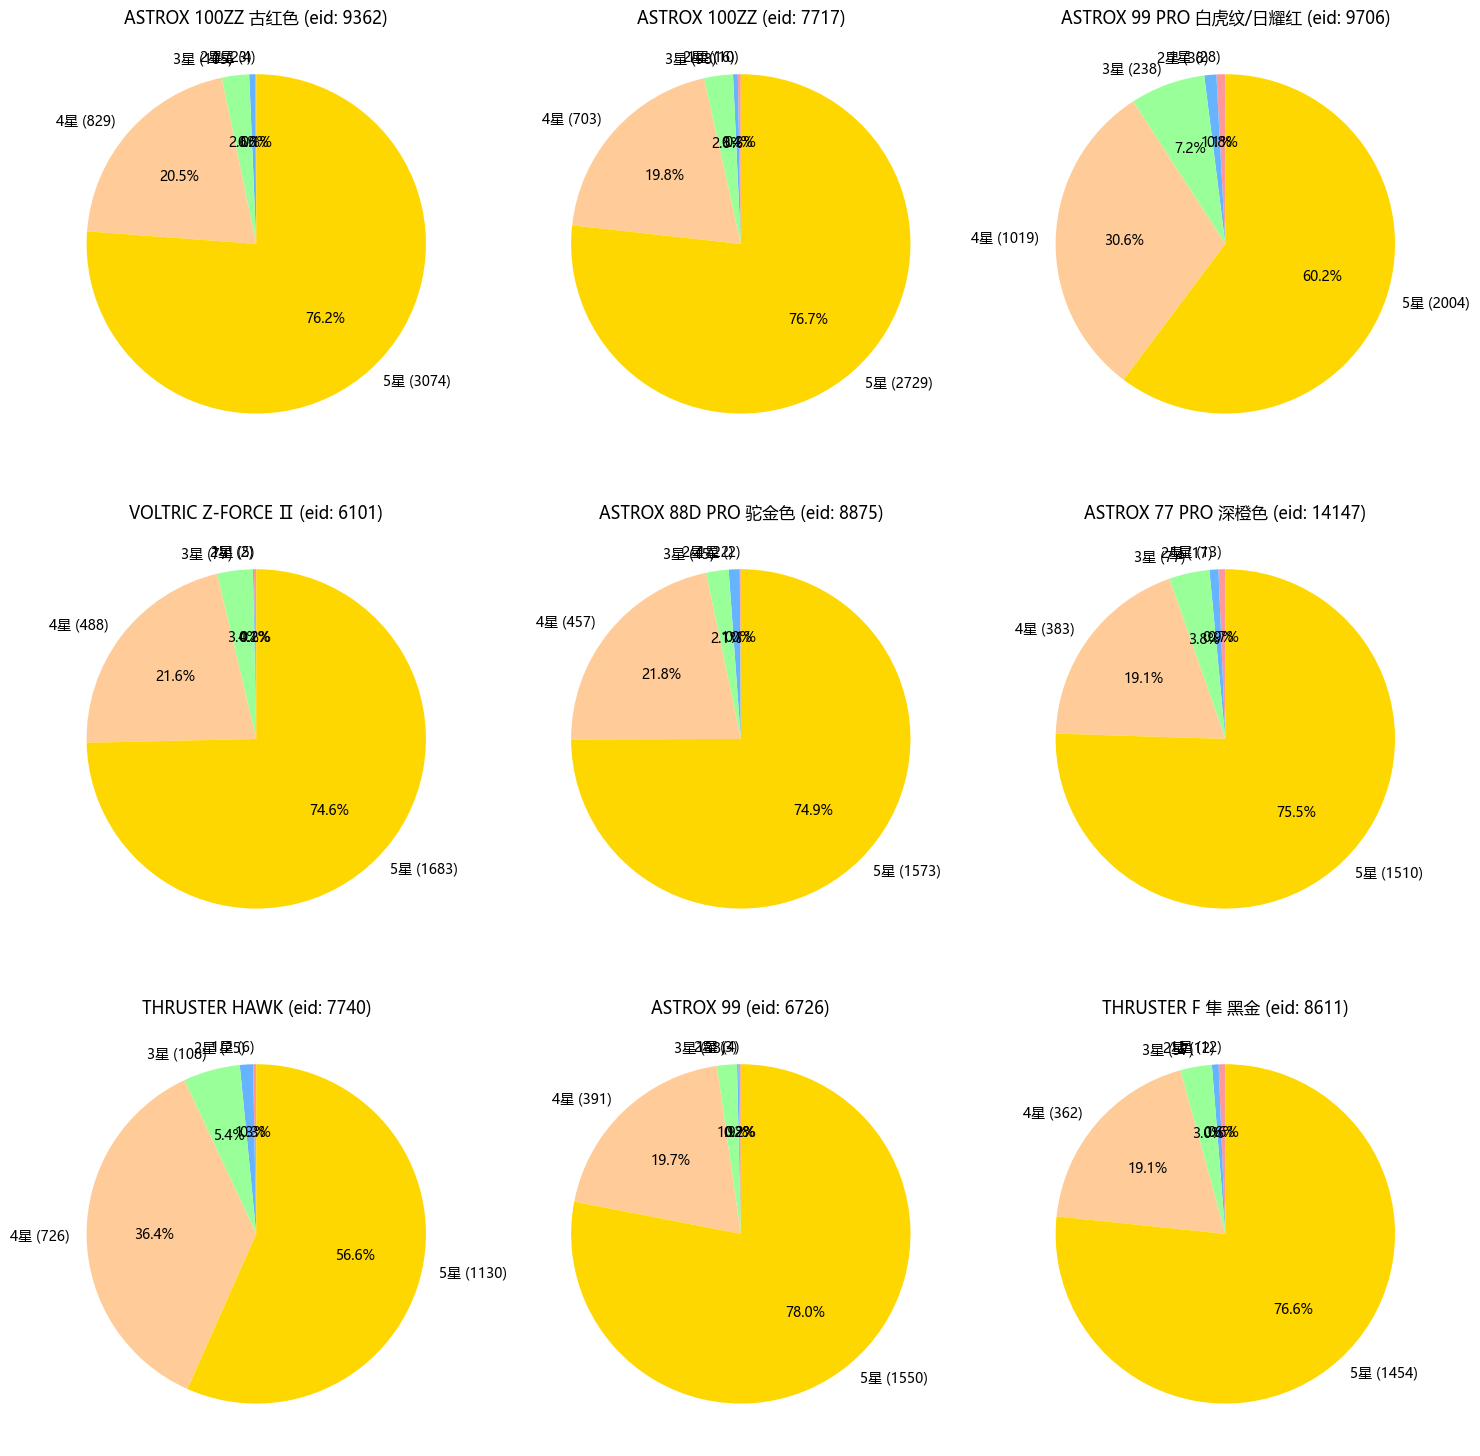

In [5]:
# 计算每个拍子的评论数量
comment_counts = sum_data.groupby('eid')['comment_id'].nunique().sort_values(ascending=False)

# 选择评论数量最多的前9个拍子
top_9_eids = comment_counts.head(9).index

# 创建 3x3 的网格
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# 定义颜色
colors=['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']

# 遍历每个 eid，绘制饼状图
for i, eid in enumerate(top_9_eids):
    # 获取当前的子图位置
    ax = axes[i // 3, i % 3]
    
    # 筛选出当前 eid 的数据
    eid_data = sum_data[sum_data['eid'] == eid]
    
    # 获取拍子名称（假设列名为 'name_usuall'）
    product_name = eid_data['name_usuall'].iloc[0]  # 获取对应的拍子名称
    
    # 统计评论的星级分布
    star_counts = eid_data['comment_star'].value_counts().sort_index()

    # 绘制饼状图，显示具体评论数量
    labels = [f'{star}星 ({count})' for star, count in zip(star_counts.index, star_counts)]
    ax.pie(star_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors[:len(star_counts)])
    
    # 设置标题
    ax.set_title(f'{product_name} (eid: {eid})')

# 调整布局以避免重叠
plt.tight_layout()

# 显示图形
plt.show()

#### 2.2 查看热度最大的9个拍子词云图

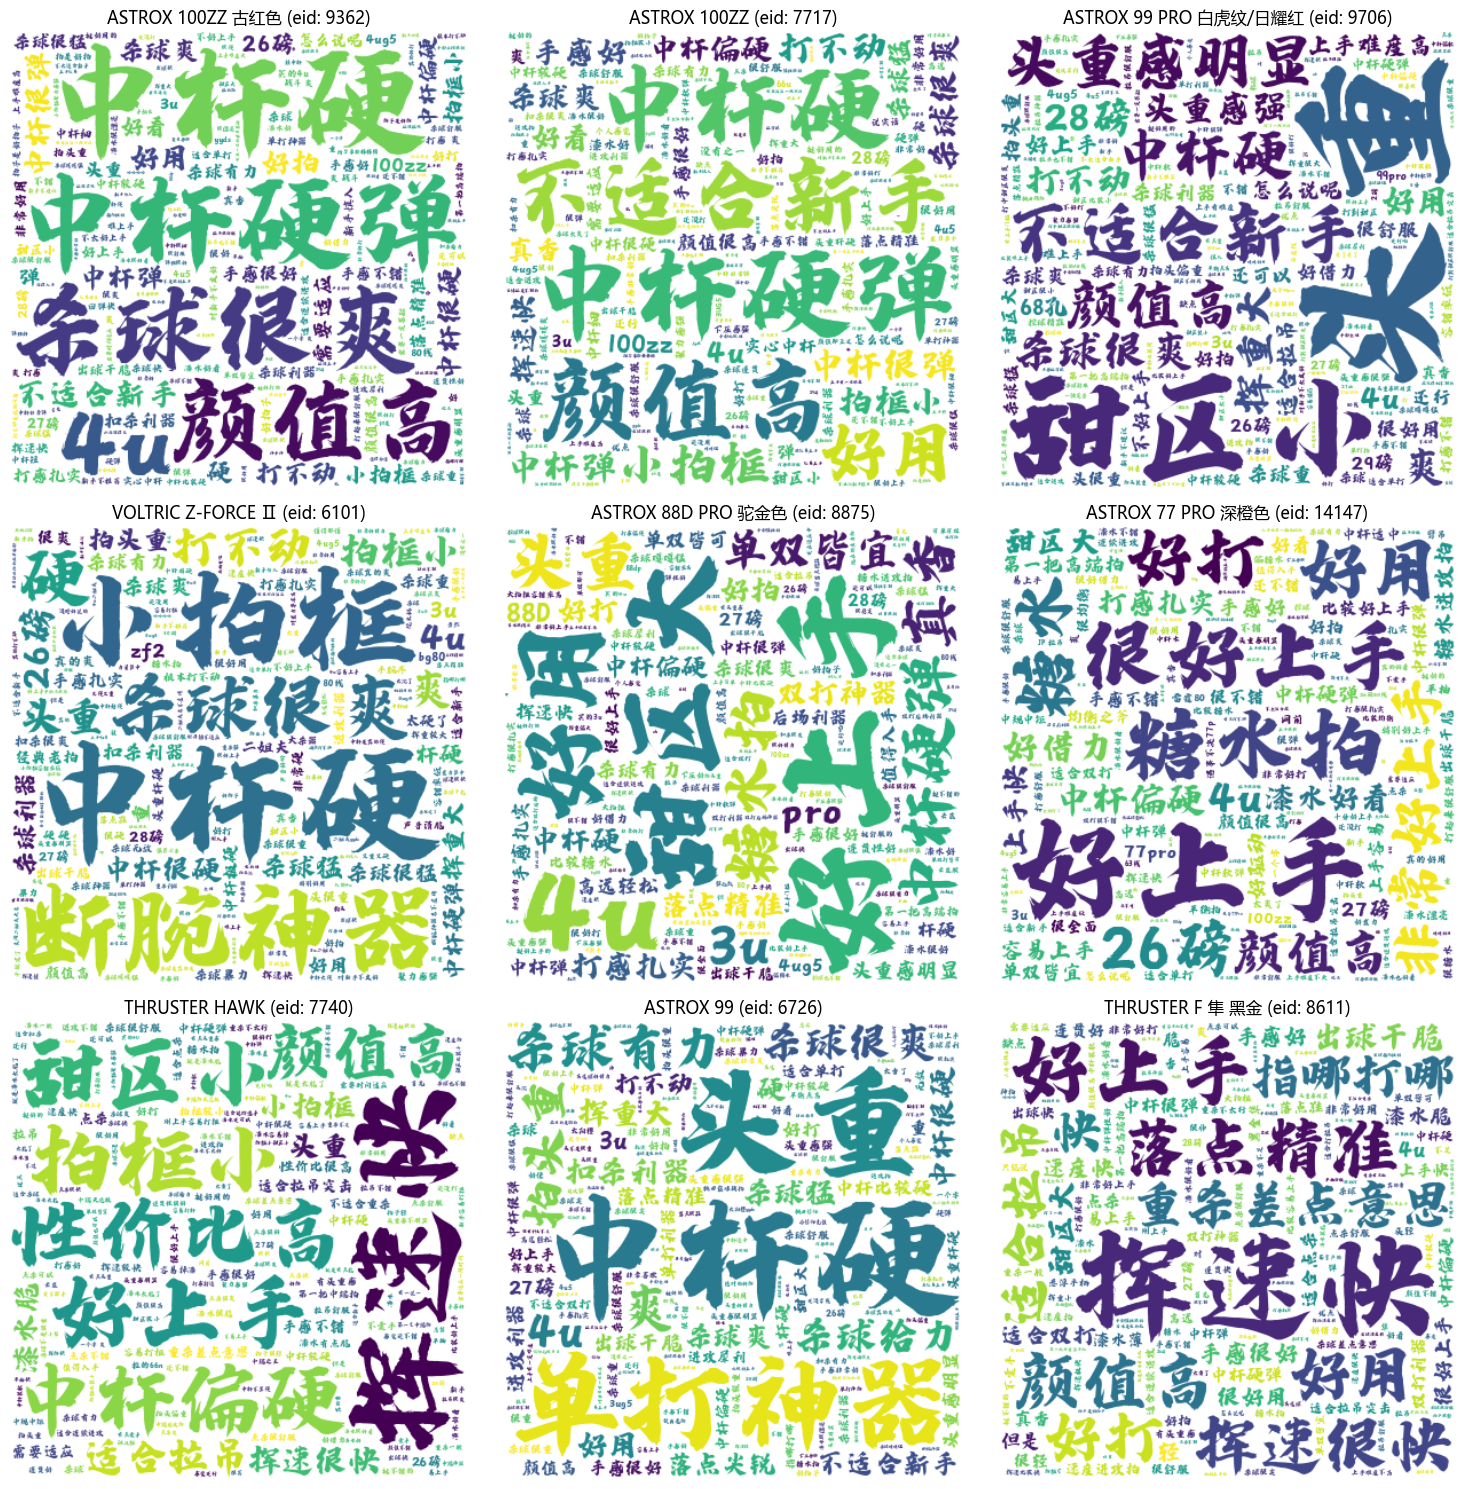

In [6]:
font_path = "data/word.ttf"
# 创建 3x3 的网格
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# 遍历每个 eid，生成词云
for i, eid in enumerate(top_9_eids):
    # 获取当前的子图位置
    ax = axes[i // 3, i % 3]
    
    # 筛选出当前 eid 的评论数据
    eid_data = sum_data[sum_data['eid'] == eid]
    
    # 获取拍子名称（假设列名为 'name_usuall'）
    product_name = eid_data['name_usuall'].iloc[0]  # 获取对应的拍子名称
    
    # 获取评论内容（假设列名为 'comment'）
    comments = ' '.join(eid_data['comment'].dropna())  # 合并所有评论为一个字符串

    # 生成词云，指定中文字体路径
    wordcloud = WordCloud(font_path=font_path, width=400, height=400, background_color='white').generate(comments)

    # 显示词云
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')  # 关闭坐标轴
    ax.set_title(f'{product_name} (eid: {eid})')

# 调整布局以避免重叠
plt.tight_layout()

# 显示图形
plt.show()

#### 2.3 羽毛球拍价格大致分布

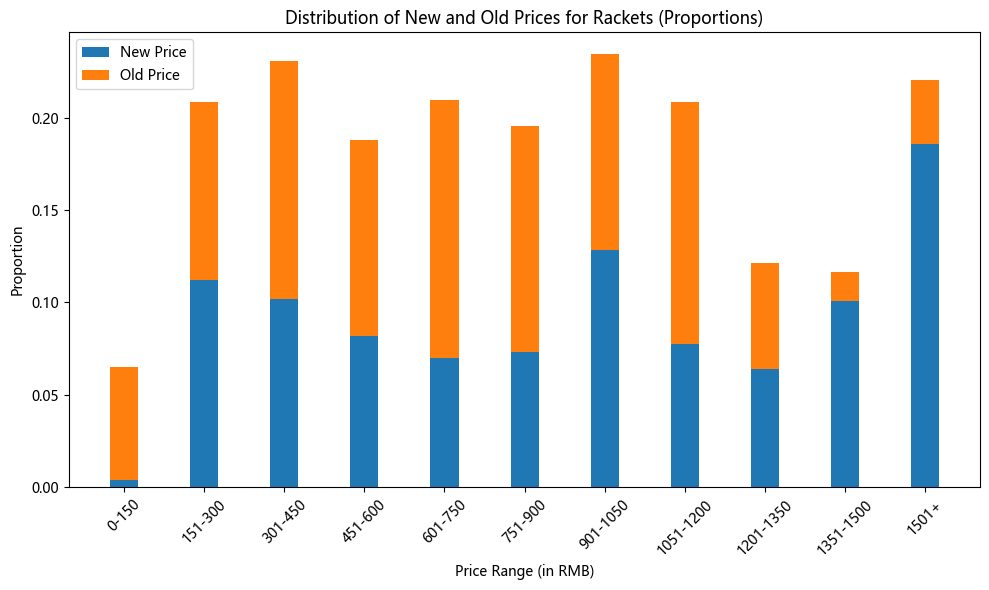

In [7]:
# 定义价格区间，区间大小为 150 元
price_bins = [0, 150, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 2000]
price_labels = ['0-150', '151-300', '301-450', '451-600', '601-750', '751-900', '901-1050', '1051-1200', '1201-1350', '1351-1500', '1501+']

# 对价格列进行分组
sum_data['new_price_bin'] = pd.cut(sum_data['price_new'], bins=price_bins, labels=price_labels, right=False)
sum_data['old_price_bin'] = pd.cut(sum_data['price_old'], bins=price_bins, labels=price_labels, right=False)

# 计算每个价格区间的数量
new_price_counts = sum_data['new_price_bin'].value_counts().sort_index()
old_price_counts = sum_data['old_price_bin'].value_counts().sort_index()

# 计算比例
new_price_proportions = new_price_counts / new_price_counts.sum()
old_price_proportions = old_price_counts / old_price_counts.sum()

# 绘制柱状图，显示比例
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.35  # 设置柱状图的宽度
labels = price_labels  # 使用我们定义的价格区间标签

# 绘制一手价格和二手价格的比例柱状图
ax.bar(labels, new_price_proportions, width, label='New Price')
ax.bar(labels, old_price_proportions, width, bottom=new_price_proportions, label='Old Price')

# 设置图表的标题和标签
ax.set_title('Distribution of New and Old Prices for Rackets (Proportions)')
ax.set_xlabel('Price Range (in RMB)')
ax.set_ylabel('Proportion')
ax.legend()

# 显示图形
plt.xticks(rotation=45)  # 旋转 x 轴标签，避免重叠
plt.tight_layout()
plt.show()


可以看到羽毛球拍的价格在各个区间都有分布，比较均匀，需要根据自己的选择，得到最适合自己的羽毛球拍

### 3. 推荐系统的实现

#### 3.1 提取一些特征词

In [8]:
# 完善的停用词列表
stop_words = set([
    '的', '了', '很', '是', '也', '不', '有', '我', '这', '在', '和', '就', '比', '也', '更', '可能', 
    '那', '一个', '非常', '不', '都', '不', '没有', '他', '它', '你', '来', '去', '要', '自己', '所以',
    '我们', '你们', '他们', '这样', '那样', '但是', '而', '可是', '要', '吗', '吧', '啊', '呀', '啦', 
    '呢', '哦', '嗯', '！', '？', '，', '。', '：', '；', '“', '”', '（', '）', '《', '》', '【', '】', 
    '［', '］', '·', '、', '《', '》', '——', '—', '﹔', '（', '）', '：', '、', '＂', '…', '——', '；', 
    '：', '！', '》', '、', '？', '【', '】', '（', '）'
])

# 读取数据
df = pd.read_csv("data/comment_data.csv")  # 替换为实际文件路径

# 清理评论数据，填充空值并转换为字符串
df['cleaned_comment'] = df['comment'].fillna("").astype(str)

# 词性过滤函数，去除无意义的词汇
def jieba_cut(text):
    words = posseg.cut(text)
    meaningful_words = [
        word for word, flag in words
        if word not in stop_words and flag in ['n', 'v', 'a']  # 保留名词、动词、形容词
    ]
    return meaningful_words

# 分词处理
df['tokenized_comment'] = df['cleaned_comment'].apply(jieba_cut)

# 准备数据，去掉空评论
tokenized_data = df['tokenized_comment'].dropna().tolist()

# 训练 Word2Vec 模型
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=2, workers=4)

# 提取所有词汇
all_words = [word for sentence in tokenized_data for word in sentence]

# 统计词频
word_freq = Counter(all_words)

# 获取出现频率最高的前100个词
top_100_words = word_freq.most_common(100)

# 按行输出前100个词
print("前100个词及其频率：")
for word, freq in top_100_words:
    print(f"{word}: {freq}")


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\binzc\AppData\Local\Temp\jieba.cache
Loading model cost 1.203 seconds.
Prefix dict has been built successfully.


前100个词及其频率：
拍: 31092
好: 27769
打: 25962
杀球: 22751
感觉: 19775
拍子: 14888
适合: 11774
不错: 11699
进攻: 10604
漆水: 9334
高: 9143
硬: 8912
有点: 8542
中杆: 8485
上手: 8188
舒服: 8166
手感: 7950
买: 7737
新手: 7704
快: 7360
手: 6999
颜值: 6932
重: 6876
框: 6767
后场: 6512
线: 6459
说: 5607
球拍: 5560
杀: 5468
小: 5407
挥速: 5360
起来: 5354
头: 5254
大: 5155
速度: 5152
发力: 5139
好看: 5098
打感: 5096
甜区: 4972
球: 4961
会: 4888
容易: 4887
轻: 4820
能: 4432
觉得: 4396
适应: 4392
拉吊: 4206
拉: 4199
糖水: 4191
需要: 4156
没: 4101
明显: 3965
平: 3894
喜欢: 3831
力量: 3720
到: 3660
入手: 3576
时候: 3452
个人: 3381
弹: 3344
重感: 3276
控球: 3168
单打: 3118
重杀: 3085
平衡点: 2964
一般: 2964
防守: 2931
轻松: 2909
使用: 2796
强: 2792
软: 2768
开始: 2742
整体: 2704
抽: 2671
借力: 2590
人: 2574
扣杀: 2570
平衡: 2562
扎实: 2488
感: 2474
挥重: 2439
性价比: 2432
出: 2419
高端: 2404
很爽: 2331
脆: 2322
控制: 2291
头重: 2271
难: 2251
球友: 2181
建议: 2173
感受: 2170
入: 2144
价格: 2134
推荐: 2127
均衡: 2100
漆: 2086
高远球: 2030
震手: 2014
拍头: 2002


#### 3.2 选出一些羽毛球爱好者常见需求作为特征值
选择如下：入门，高端，性价比，暴力，进攻，杀球，控制，头重，连贯，速度，中杆硬，中杆软，糖水，颜值，拉吊

使用bert-base-chinese预训练模型，利用人工标注的数据train_data微调模型，实现评论的多标签分类

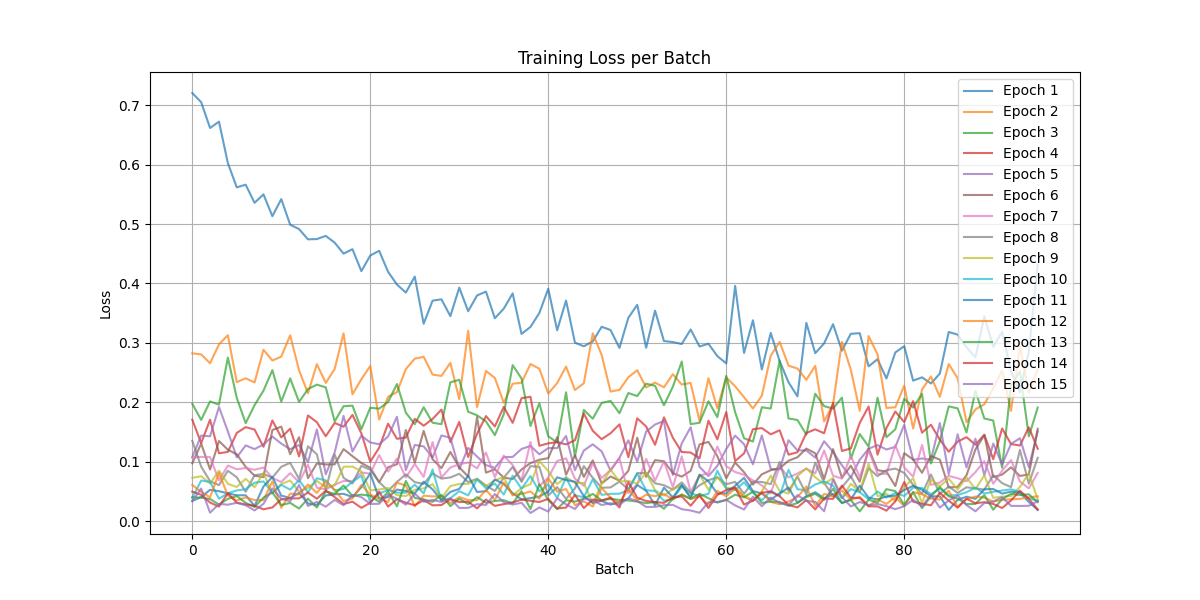

### 3.3 训练完成，对现有数据进行标签化

##### 3.3.1 给评论数据加上标签
预测模型太慢了，所以使用异步调用实现并行增大速率，此处大约花了三个小时才预测完

In [1]:


# 配置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

LABELS = ['入门', '高端', '性价比', '暴力', '进攻', '杀球', '控制', '头重', '连贯', '速度', '中杆硬', '中杆软',
              '糖水', '颜值', '拉吊']
# 定义异步函数，用于调用模型预测
async def async_predict(tool, comment, LABELS, idx):
    # 使用异步调用获取预测标签
    predicted_labels = await asyncio.to_thread(tool.get_predict_values, comment)
    label_values = [1 if label in predicted_labels else 0 for label in LABELS]

    # 输出当前处理的索引信息
    logging.info(f"Processed row {idx}, labels: {label_values}")
    return label_values


async def process_comments(comment_data, tool, LABELS):
    tasks = []

    # 创建异步任务列表
    for idx, row in comment_data.iterrows():
        comment = row['comment']  # 获取评论文本
        tasks.append(async_predict(tool, comment, LABELS, idx))  # 为每条评论创建任务

    # 等待所有异步任务完成，并收集结果
    results = await asyncio.gather(*tasks)

    # 将结果存入 DataFrame
    for idx, label_values in zip(comment_data.index, results):
        comment_data.loc[idx, LABELS] = label_values
        # 输出处理完成的信息
        logging.info(f"Finished processing row {idx}")

    logging.info("All rows processed successfully!")


if os.path.exists("data/comment_data_with_tags.csv"):
    comment_data_tags = pd.read_csv("data/comment_data_with_tags.csv")
    logging.info("Loaded pre-existing data from comment_data_with_tags.csv")
    print(comment_data_tags.head(10))
else:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Model')))
    from model import Tools

    tool = Tools("../Model/models")
    

    # 加载 comment_data.csv 文件
    comment_data = pd.read_csv('data/comment_data.csv')
    logging.info(f"Loaded {len(comment_data)} rows from comment_data.csv")

    # 处理缺失的评论，将 NaN 替换为空字符串或其他值
    comment_data['comment'] = comment_data['comment'].fillna("")

    # 定义一个空的 DataFrame 用于保存处理后的数据
    comment_data_tags = comment_data.copy()

    # 使用异步处理模型预测
    logging.info("Start processing comments with labels prediction...")
    asyncio.run(process_comments(comment_data_tags, tool, LABELS))

    # 打印或者保存处理后的数据
    logging.info("Saving the processed data to comment_data_with_tags.csv")
    print(comment_data_tags.head(10))
    comment_data_tags.to_csv('data/comment_data_with_tags.csv', index=False)
    logging.info("Data saved successfully!")


2024-12-26 00:03:26,096 - Loaded pre-existing data from comment_data_with_tags.csv


     eid  comment_id  comment_star  \
0   2106      laker陈             5   
1   2106         欢小少             4   
2  11063       云云云13             5   
3  11063   Chauffeur             5   
4  11063      尘儇_Ep1             5   
5  11063    JukJoeNG             5   
6  11063  JJJJJJacey             5   
7  11063       执迷-不悟             4   
8  11063    ForrestZ             5   
9  11063     Simslim             5   

                                             comment comment_ava_star   入门  \
0  这拍子 号称坐标原点的拍子 就是中杆跟拍子一个整体的感觉，虽然是2U的拍子，但没有头重感 很...             数据量少  0.0   
1                                        还是圆头.......             数据量少  0.0   
2  新手上手并不是很难，拉的26磅，击球声音好听，高远球和反手都没有以前那么费力了，身边的猛男用...              9.3  1.0   
3  速度其实没有想象中的特别快\r\n同是4u 且为全破风框型球拍\r\nnf700的空气动力学...              9.3  0.0   
4  新人第一支高端拍，总之就是非常好看，空拍刚到手没拉线，漆水很绝，打算上63线配as线，高中之...              9.3  0.0   
5  冲着5u，破风框高端拍，中杆硬度适中，低平衡点这几大特性买的，红色到手非常惊艳，首线配上红白...              9.3  0.0   
6  太好上手的拍子了，用过以后才意识到，以前买的77p，99p都打了

##### 3.3.2 计算出eid所对应15个标签得概率取值
为了避免某些只有几条评论的数据造成干扰，测试的过程发现存在只有一条评论的球拍，由于那一条评论符合特征，导致球拍那个特征分值较高，出现了异常，故而使用sigmod函数使得评论在50以上的时候，得分才可靠具有较大权值，低于50条评论，都认为不可靠

In [3]:
# 定义 Sigmoid 函数
def sigmoid(x, alpha=1, beta=0):
    return 1 / (1 + np.exp(-alpha * (x - beta)))
# 按eid分组，计算每个标签为1的数量
grouped = comment_data_tags.groupby('eid')[LABELS].sum()
# 统计每个eid的评论数量
comment_counts = comment_data_tags.groupby('eid')['comment'].count()
# 计算每个标签的概率，标签为1的数量 / 总评论数量
goods = grouped.div(comment_counts, axis=0)
# 计算 Sigmoid 权重
sigmoid_weights = sigmoid(comment_counts, alpha=0.1, beta=50)
# 加权得分
sigmoid_weighted_scores = goods.mul(sigmoid_weights, axis=0)

print(sigmoid_weighted_scores[LABELS].min())
print(sigmoid_weighted_scores[LABELS].max())
print(sigmoid_weighted_scores.head(10))

入门     0.0
高端     0.0
性价比    0.0
暴力     0.0
进攻     0.0
杀球     0.0
控制     0.0
头重     0.0
连贯     0.0
速度     0.0
中杆硬    0.0
中杆软    0.0
糖水     0.0
颜值     0.0
拉吊     0.0
dtype: float64
入门     0.509753
高端     0.065468
性价比    0.182538
暴力     0.477543
进攻     0.188888
杀球     0.411384
控制     0.058587
头重     0.059756
连贯     0.077031
速度     0.404190
中杆硬    0.315985
中杆软    0.079325
糖水     0.335750
颜值     0.480144
拉吊     0.191576
dtype: float64
           入门        高端       性价比        暴力        进攻        杀球        控制  \
eid                                                                         
28   0.000000  0.001799  0.001799  0.001799  0.000000  0.001799  0.000000   
31   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
36   0.000000  0.000000  0.008074  0.006055  0.000000  0.004037  0.000000   
58   0.001811  0.000000  0.000000  0.003623  0.001811  0.001811  0.000000   
197  0.000000  0.000000  0.002738  0.000000  0.002738  0.000000  0.002738   
319  0.001912  0.000000  0

##### 3.3.1 与info_data表连接

In [4]:
info_data = pd.read_csv("data/info_data.csv")
info_data_selected = info_data[['eid','name_usuall','brand','racket_weight','price_old','price_new']]
data = pd.merge(info_data_selected, sigmoid_weighted_scores, on='eid', how='inner')  # 使用 'inner' 合并方式
print(data.head(10))

     eid         name_usuall       brand racket_weight  price_old  price_new  \
0  20985  NANOFLARE 700 TOUR  尤尼克斯 YONEX         4U、5U      563.0      685.0   
1  18736      ASTROX 3 DG HF  尤尼克斯 YONEX            4U      346.0      433.0   
2   8491  ARCSABER TOUR 1000  尤尼克斯 YONEX         3U、4U      784.0      980.0   
3   6713      Nanospeed 1000  尤尼克斯 YONEX            3U     1400.0     1750.0   
4   6697     JETSPEED S 12 F  威克多 VICTOR         3U、4U     1078.0     1037.0   
5  17826     AURASPEED ETA瑶光  威克多 VICTOR         3U、4U      358.0      442.0   
6   7451     THRUSTER K 66 I  威克多 VICTOR            7U      317.0      396.0   
7  20362      AURASPEED 2800  威克多 VICTOR             -      222.0      278.0   
8   8516    BRAVE SWORD 1800  威克多 VICTOR         3U、4U      226.0      283.0   
9   7569       THRUSTER K 70  威克多 VICTOR            6U      212.0      265.0   

         入门        高端       性价比        暴力  ...        杀球       控制        头重  \
0  0.008394  0.000000  0.020985  0.04197

##### 3.3.2 由于标签值大多比较低，对标签值进行归一化，使得欧式距离更正确
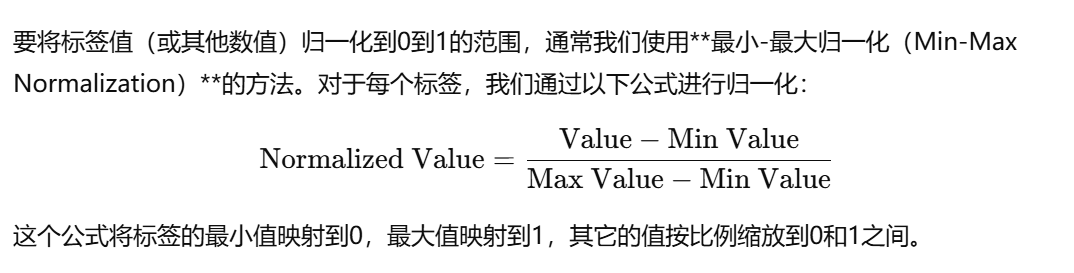

In [5]:

# 创建MinMaxScaler实例
scaler = MinMaxScaler()
# 对标签列进行
data[LABELS] = scaler.fit_transform(data[LABELS])
print(data[LABELS].min())
print(data[LABELS].max())
print(data.head(10))

入门     0.0
高端     0.0
性价比    0.0
暴力     0.0
进攻     0.0
杀球     0.0
控制     0.0
头重     0.0
连贯     0.0
速度     0.0
中杆硬    0.0
中杆软    0.0
糖水     0.0
颜值     0.0
拉吊     0.0
dtype: float64
入门     1.0
高端     1.0
性价比    1.0
暴力     1.0
进攻     1.0
杀球     1.0
控制     1.0
头重     1.0
连贯     1.0
速度     1.0
中杆硬    1.0
中杆软    1.0
糖水     1.0
颜值     1.0
拉吊     1.0
dtype: float64
     eid         name_usuall       brand racket_weight  price_old  price_new  \
0  20985  NANOFLARE 700 TOUR  尤尼克斯 YONEX         4U、5U      563.0      685.0   
1  18736      ASTROX 3 DG HF  尤尼克斯 YONEX            4U      346.0      433.0   
2   8491  ARCSABER TOUR 1000  尤尼克斯 YONEX         3U、4U      784.0      980.0   
3   6713      Nanospeed 1000  尤尼克斯 YONEX            3U     1400.0     1750.0   
4   6697     JETSPEED S 12 F  威克多 VICTOR         3U、4U     1078.0     1037.0   
5  17826     AURASPEED ETA瑶光  威克多 VICTOR         3U、4U      358.0      442.0   
6   7451     THRUSTER K 66 I  威克多 VICTOR            7U      317.0      396.0   


##### 3.3.4 将系统所需要用到的数据，保存到data.csv文件中去，包含的信息是eid，品牌，重量，价格，15个标签值

In [6]:
data.to_csv('data/data.csv', index=False)
logging.info("Data saved successfully!")

2024-12-26 00:05:04,332 - Data saved successfully!


#### 3.4 向量空间构建完成，实现根据用户需求的推荐

用户可以输入品牌，重量，价格区间，这些是硬性条件必须要满足，这些条件先将数据过滤一遍

In [ ]:
用户可以选择15个标签中的任意标签，设置相应的值和权重，系统会计算加权欧式距离，系统会推荐欧式距离最小的10个球拍

In [33]:
data = pd.read_csv('data/data.csv')
def filters(data_all, brand=None, weight=None, price_start=0, price_end=1000000):
    data = data_all.copy()
    """根据品牌、重量和价格过滤数据"""
    if brand:
        data = data[data['brand'].isin(brand)]  # 使用 isin 进行品牌过滤
    if weight:
        # 遍历每个用户指定的重量并检查是否为子串
        weight_condition = data['racket_weight'].apply(lambda x: any(w in x for w in weight))
        data = data[weight_condition]
    data = data[(data['price_new'] >= price_start) & (data['price_new'] <= price_end)]
    return data


def get_recommendations(brand=None, weight=None, price_start=0, price_end=1000000,labels=None):
    filtered_data = filters(data, brand, weight, price_start, price_end)
    if labels is None:
        return filtered_data.head(10)
    else:
        distances = []
        for _, row in filtered_data.iterrows():
            distance = 0
            for label,(value,weight) in labels.items():
                diff = row[label] - value
                distance += (diff ** 2) * weight
            distances.append(np.sqrt(distance))
        filtered_data['distance'] = distances
        return filtered_data.sort_values('distance').head(10)

brand = ['李宁 Lining']
weight = ['3U','4U']
labels={
    "杀球":[0.8,9],
    "暴力":[0.9,1],
    "颜值":[1,10]
}
recommendations=get_recommendations(brand=brand,weight=weight,labels=labels,price_start=300,price_end=500)
print(recommendations)

       eid         name_usuall      brand racket_weight  price_old  price_new        入门        高端       性价比  ...        头重        连贯        速度       中杆硬       中杆软        糖水        颜值        拉吊  distance
450  11095          TECTONIC 6  李宁 Lining         4U、5U      300.0      460.0  0.099028  0.207408  0.069136  ...  0.422385  0.000000  0.062446  0.239630  0.000000  0.225523  0.473105  0.263497  1.703460
426  11088               锋影500  李宁 Lining         3U、4U      400.0      491.0  0.057887  0.269426  0.449043  ...  0.109737  0.383070  0.762505  0.155641  0.123996  0.341784  0.491655  0.273829  1.713215
482   6710         Flame N55 Ⅲ  李宁 Lining        W3（3U）      334.0      417.0  0.037556  0.314636  0.000000  ...  0.000000  0.124264  0.142094  0.302930  0.120669  0.142549  0.398720  0.149896  1.922545
331   8388      AERONAUT 6000C  李宁 Lining        W3（3U）      309.0      386.0  0.136993  0.137723  0.260144  ...  0.560945  0.290096  0.179682  0.123759  0.211279  0.216309  0.372327  0.33

展示第一个推荐拍子的词云图，可见的确是杀球颜值为主要词云，推荐系统确实起作用了

D:\bzcEdit\Py\BusinessIntelligence\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\bzcEdit\Py\BusinessIntelligence\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


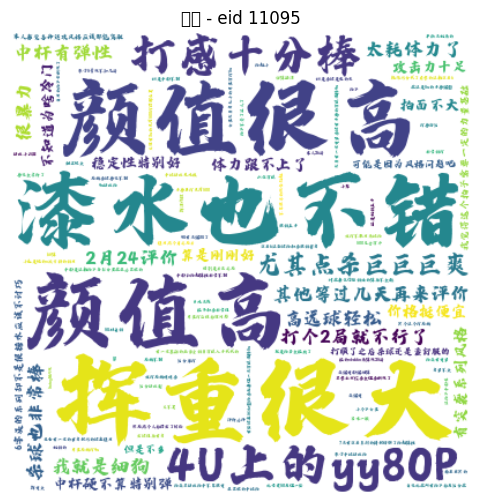

In [36]:
comment_data = pd.read_csv("data/comment_data_with_tags.csv")
if(len(recommendations)<1):
    print("error,无推荐")
else:
    recommendation_first = recommendations.head(1)
    # 1. 获取第一个推荐的 eid
    first_eid = recommendation_first['eid'].iloc[0]
    first_group = comment_data[comment_data['eid'] == first_eid]
    # 3. 获取该组所有评论文本
    text = ' '.join(first_group['comment'])
    
    # 4. 生成词云，指定中文字体路径
    wordcloud = WordCloud(font_path="data/word.ttf", width=400, height=400, background_color='white').generate(text)
    
    # 5. 显示词云图
    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"词云 - eid {first_eid}")
    plt.axis('off')  # 不显示坐标轴
    plt.show()